In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!pip install --quiet google-cloud-bigquery

In [ ]:
from google.cloud import bigquery
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For feature importance plot
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set your project and dataset
project_id = "sandbox-b1"
dataset_id = "safe_prod_exploration"

# Initialize BigQuery client
client = bigquery.Client(project=project_id)

# List all tables in the dataset
tables = client.list_tables(dataset_id)

# Collect row counts
table_stats = []

for table in tables:
    table_id = f"{project_id}.{dataset_id}.{table.table_id}"
    table_ref = client.get_table(table_id)

    table_stats.append({
        "table_name": table.table_id,
        "row_count": table_ref.num_rows
    })

# Convert to DataFrame
row_counts_df = pd.DataFrame(table_stats).sort_values(by="row_count", ascending=False)

# Show result
row_counts_df

,table_name,row_count
2,bq_company_variables_tsm,1473117848
1,bq_company_variables_ts,536053840
9,bq_linkedin_people,521557783
3,bq_company_variables_tsq,481122188
7,bq_google_places,217714929
4,bq_firmographics,74172708
0,bq_company_variables_mr,63610529
10,bq_overture_places,62270552
8,bq_linkedin_companies,57467204
15,crunchbase_non_US,3628695


In [ ]:
query = """
SELECT *
FROM `sandbox-b1.safe_prod_exploration.crunchbase_labels`
"""

# Run the query and convert to a Pandas DataFrame
df = client.query(query).to_dataframe()

# Show sample results
df

NotFound: 404 Not found: Table sandbox-b1:safe_prod_exploration.crunchbase_labels was not found in location us-west1; reason: notFound, message: Not found: Table sandbox-b1:safe_prod_exploration.crunchbase_labels was not found in location us-west1

Location: us-west1
Job ID: ebcbf545-2fde-4210-911f-03a6f9dd7d2d


In [ ]:
query = """
SELECT *
FROM `sandbox-b1.safe_prod_exploration.crunchbase_label_final`
"""

# Run the query and convert to a Pandas DataFrame
df = client.query(query).to_dataframe()

# Show sample results
df

,name,category,country,confidence_score,website_url_binary,twitter_binary,linkedin_binary,location_identifiers_value_binary,phone_number_binary,short_description_binary,...,operating_status_encoded,revenue_range_encoded,rank_band,num_employees_encoded,ipo_status_encoded,years_since_founded,years_since_founded_band,company_type_encoded,days_since_updated,has_category_groups
0,Stuffed Puffs,Food and Beverage,United States,92,1,1,1,1,1,1,...,1,3,3,3,0,8,8,2,335,1
1,Other Tomorrows,Advertising,United States,84,1,0,1,1,1,1,...,1,2,1,1,0,6,6,2,943,1
2,Thompson Consulting,Professional Services,United States,97,1,0,0,1,1,1,...,1,0,1,1,0,30,12,2,1392,1
3,CCP,Energy,United Kingdom,50,0,0,0,1,0,1,...,1,0,1,0,0,0,0,0,1456,1
4,Paygen,Financial Services,United States,66,1,0,1,1,1,1,...,1,2,2,1,0,5,5,2,1007,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231386,MCS Technology Consulting,Information Technology,United States,88,1,0,0,1,1,1,...,1,0,1,1,0,7,7,2,280,1
231387,Chrisanntha,Real Estate,United States,85,1,1,1,1,1,1,...,1,1,1,1,0,0,0,2,951,1
231388,Algoritm,Advertising,Russian Federation,100,1,0,0,1,1,1,...,1,0,1,0,0,0,0,2,1343,1
231389,Bituminous Materials,Real Estate,United States,83,1,0,1,1,1,1,...,1,3,1,3,0,62,12,2,727,1


In [ ]:
print(df.describe())

       confidence_score  website_url_binary  twitter_binary  linkedin_binary  \
count          231391.0            231391.0        231391.0         231391.0   
mean          85.836191            0.992385        0.457217         0.867558   
std           16.690397             0.08693        0.498167         0.338972   
min                 0.0                 0.0             0.0              0.0   
25%                76.0                 1.0             0.0              1.0   
50%                91.0                 1.0             0.0              1.0   
75%               100.0                 1.0             1.0              1.0   
max               100.0                 1.0             1.0              1.0   

       location_identifiers_value_binary  phone_number_binary  \
count                           231391.0             231391.0   
mean                                 1.0             0.858763   
std                                  0.0             0.348267   
min                

In [ ]:
num_dup = df.duplicated().sum()
print(f"Number of duplicate rows (excluding first occurrences): {num_dup}")

Number of duplicate rows (excluding first occurrences): 0


In [ ]:
print(df.nunique())

name                                 210614
category                                 45
country                                 177
confidence_score                         61
website_url_binary                        2
twitter_binary                            2
linkedin_binary                           2
location_identifiers_value_binary         1
phone_number_binary                       2
short_description_binary                  1
legal_name_binary                         1
identifier_permalink_binary               1
contact_email_binary                      2
status_encoded                            4
operating_status_encoded                  2
revenue_range_encoded                     9
rank_band                                 5
num_employees_encoded                    10
ipo_status_encoded                        3
years_since_founded                     298
years_since_founded_band                 13
company_type_encoded                      3
days_since_updated              

In [ ]:
# Calculate the fill rate for 'confidence_score'
fill_rate = df['confidence_score'].count() / len(df)

print(f"Fill rate for 'confidence_score': {fill_rate:.2f}")

Fill rate for 'confidence_score': 1.00


In [ ]:
# Assuming the dataframe with <NA> values is the one loaded from 'crunchbase_label_final'
# If you loaded it into a different variable name, please adjust accordingly.

# Convert the column to numeric, coercing errors to NaN
numeric_counts = pd.to_numeric(df['confidence_score'], errors='coerce').notna().sum()

# Calculate the percentage of numerical values
percentage_numeric = (numeric_counts / len(df)) * 100

print(f"Percentage of numerical values in 'confidence_score': {percentage_numeric:.2f}%")

Percentage of numerical values in 'confidence_score': 100.00%


In [ ]:
df.columns

Index(['name', 'category', 'country', 'confidence_score', 'website_url_binary',
       'twitter_binary', 'linkedin_binary',
       'location_identifiers_value_binary', 'phone_number_binary',
       'short_description_binary', 'legal_name_binary',
       'identifier_permalink_binary', 'contact_email_binary', 'status_encoded',
       'operating_status_encoded', 'revenue_range_encoded', 'rank_band',
       'num_employees_encoded', 'ipo_status_encoded', 'years_since_founded',
       'years_since_founded_band', 'company_type_encoded',
       'days_since_updated', 'has_category_groups'],
      dtype='object')

In [ ]:
# Check for missing values, dtypes, and select features/target
print(df.info())
print(df.isnull().sum().sort_values(ascending=False).head(10))

# Define X and y
target = 'confidence_score'
X = df.drop(columns=[target, 'name', 'category', 'country'])
y = df[target]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231391 entries, 0 to 231390
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   name                               231391 non-null  object
 1   category                           226779 non-null  object
 2   country                            231391 non-null  object
 3   confidence_score                   231391 non-null  Int64 
 4   website_url_binary                 231391 non-null  Int64 
 5   twitter_binary                     231391 non-null  Int64 
 6   linkedin_binary                    231391 non-null  Int64 
 7   location_identifiers_value_binary  231391 non-null  Int64 
 8   phone_number_binary                231391 non-null  Int64 
 9   short_description_binary           231391 non-null  Int64 
 10  legal_name_binary                  231391 non-null  Int64 
 11  identifier_permalink_binary        231391 non-null  

In [ ]:
print("NaNs in target:", df['confidence_score'].isna().sum())
print("Unique values in target:", df['confidence_score'].unique())

NaNs in target: 0
Unique values in target: <IntegerArray>
[ 92,  84,  97,  50,  66, 100,  75,  65,  98,  80,  76,  78,  70,  83,  68,
   0,  87,  86,  96,  63,  95,  91,  89,  77,  90,  88,  73,  72,  71,  94,
  99,  85,  67,  74,  93,  82,  81,  61,  79,  57,  58,  62,  59,  51,  46,
  60,  53,  64,  69,  56,  43,  54,  47,  48,  44,  52,  45,  39,  55,  49,
  42]
Length: 61, dtype: Int64


In [ ]:
df = df[~df['confidence_score'].isna()].copy()

In [ ]:
print(df['confidence_score'].apply(lambda x: type(x)).value_counts())
print(df['confidence_score'].head(10))

confidence_score
<class 'int'>    231391
Name: count, dtype: int64
0     92
1     84
2     97
3     50
4     66
5    100
6     75
7     66
8    100
9     65
Name: confidence_score, dtype: Int64


In [ ]:
df['confidence_score'] = pd.to_numeric(df['confidence_score'], errors='coerce')
print("NaNs after conversion:", df['confidence_score'].isna().sum())
df = df[~df['confidence_score'].isna()].copy()

NaNs after conversion: 0


In [ ]:
# 80% train, 20% test, random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (185112, 20), Test shape: (46279, 20)


In [ ]:
print("NaNs in y_train:", y_train.isna().sum())
print("NaNs in y_test:", y_test.isna().sum())

NaNs in y_train: 0
NaNs in y_test: 0


In [ ]:
# Remove rows with any NaN in the dataframe
df = df.dropna().copy()

In [ ]:
print("NaNs in X_train:", X_train.isna().sum().sum())
print("NaNs in X_test:", X_test.isna().sum().sum())
print("NaNs in y_train:", y_train.isna().sum())
print("NaNs in y_test:", y_test.isna().sum())

# Fill NaNs with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

NaNs in X_train: 0
NaNs in X_test: 0
NaNs in y_train: 0
NaNs in y_test: 0


In [ ]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluation
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression:\nMAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, R²: {r2_lr:.2f}")

Linear Regression:
MAE: 10.38, RMSE: 12.48, R²: 0.45


In [ ]:
# Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Ridge Regression:\nMAE: {mae_ridge:.2f}, RMSE: {rmse_ridge:.2f}, R²: {r2_ridge:.2f}")

# Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso Regression:\nMAE: {mae_lasso:.2f}, RMSE: {rmse_lasso:.2f}, R²: {r2_lasso:.2f}")

Ridge Regression:
MAE: 10.38, RMSE: 12.48, R²: 0.45
Lasso Regression:
MAE: 10.49, RMSE: 12.53, R²: 0.44


In [ ]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest:\nMAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R²: {r2_rf:.2f}")

Random Forest:
MAE: 10.93, RMSE: 13.54, R²: 0.35


In [ ]:
# Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)
print(f"Gradient Boosting:\nMAE: {mae_gb:.2f}, RMSE: {rmse_gb:.2f}, R²: {r2_gb:.2f}")

Gradient Boosting:
MAE: 10.19, RMSE: 12.29, R²: 0.46


In [ ]:
# XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Regression:\nMAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.2f}")

XGBoost Regression:
MAE: 10.13, RMSE: 12.27, R²: 0.46


In [ ]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'MAE': [mae_lr, mae_ridge, mae_lasso, mae_rf, mae_gb, mae_xgb],
    'RMSE': [rmse_lr, rmse_ridge, rmse_lasso, rmse_rf, rmse_gb, rmse_xgb],
    'R²': [r2_lr, r2_ridge, r2_lasso, r2_rf, r2_gb, r2_xgb]
})
results.sort_values(by='R²', ascending=False)

,Model,MAE,RMSE,R²
5,XGBoost,10.134153,12.270006,0.463793
4,Gradient Boosting,10.187189,12.294685,0.461634
1,Ridge,10.381918,12.482403,0.445068
0,Linear Regression,10.381767,12.482412,0.445068
2,Lasso,10.489494,12.533395,0.440525
3,Random Forest,10.934467,13.535443,0.347489


In [ ]:
# Coefficients for Linear Regression
coef_df = pd.DataFrame({'feature': X.columns, 'coef': lr.coef_})
coef_df = coef_df.sort_values('coef', key=abs, ascending=False)
coef_df

,feature,coef
10,operating_status_encoded,8.716604e+01
4,phone_number_binary,4.199295e+00
0,website_url_binary,1.059790e+00
19,has_category_groups,1.023222e+00
8,contact_email_binary,-7.597867e-01
9,status_encoded,-7.458339e-01
14,ipo_status_encoded,-6.200591e-01
11,revenue_range_encoded,5.076258e-01
13,num_employees_encoded,4.710600e-01
2,linkedin_binary,3.908263e-01


In [ ]:
# Example: Predict on new sample (using the first row of X_test)
sample = X_test.iloc[[0]]
pred = rf.predict(sample)
print(f"Predicted confidence score (Random Forest): {pred[0]:.2f}")
print(f"Actual confidence score: {y_test.iloc[0]}")

Predicted confidence score (Random Forest): 73.90
Actual confidence score: 83


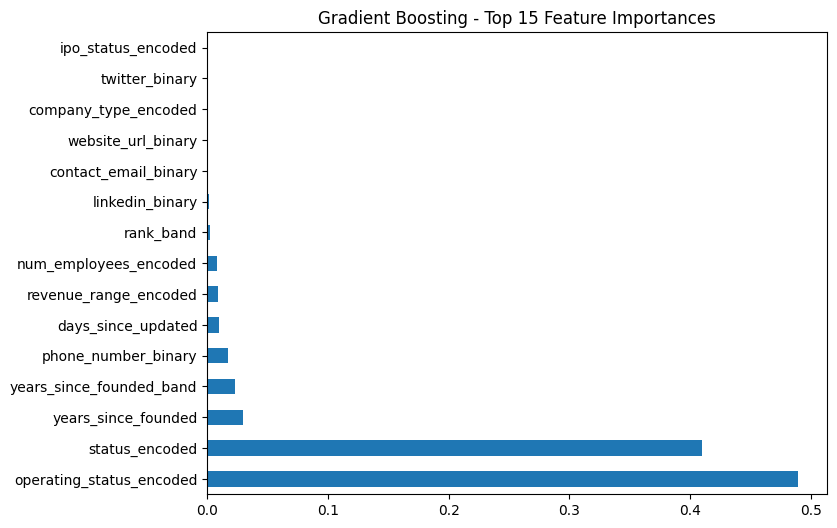

In [ ]:
# Gradient Boosting importance
importances = gb.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', figsize=(8,6))
plt.title("Gradient Boosting - Top 15 Feature Importances")
plt.show()

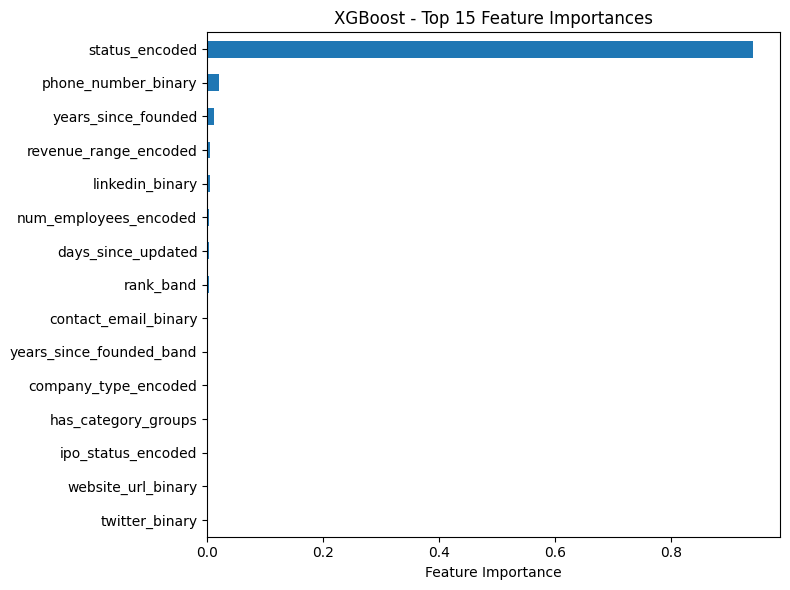

In [ ]:
# XGBoost importance
importances = xgb.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)
top15 = feat_importances.nlargest(15).sort_values(ascending=True)
top15.plot(kind='barh', figsize=(8,6))
plt.title("XGBoost - Top 15 Feature Importances")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

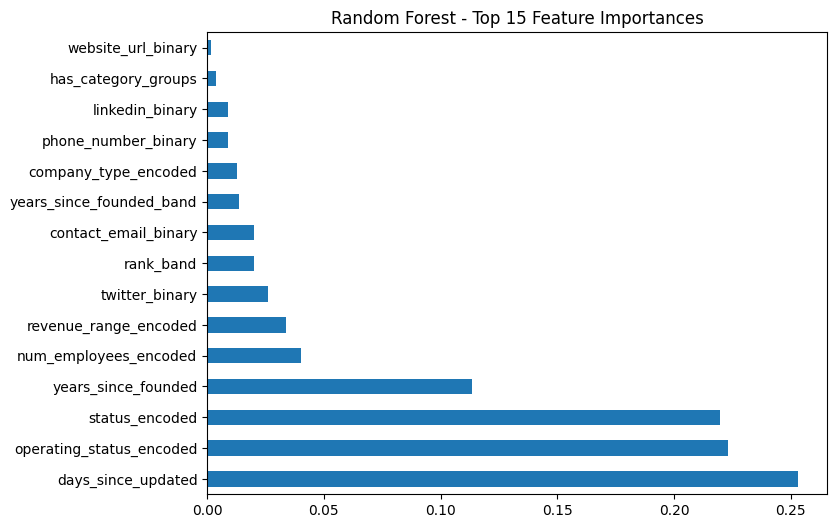

In [ ]:
# Random Forest feature importance
importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', figsize=(8,6))
plt.title("Random Forest - Top 15 Feature Importances")
plt.show()

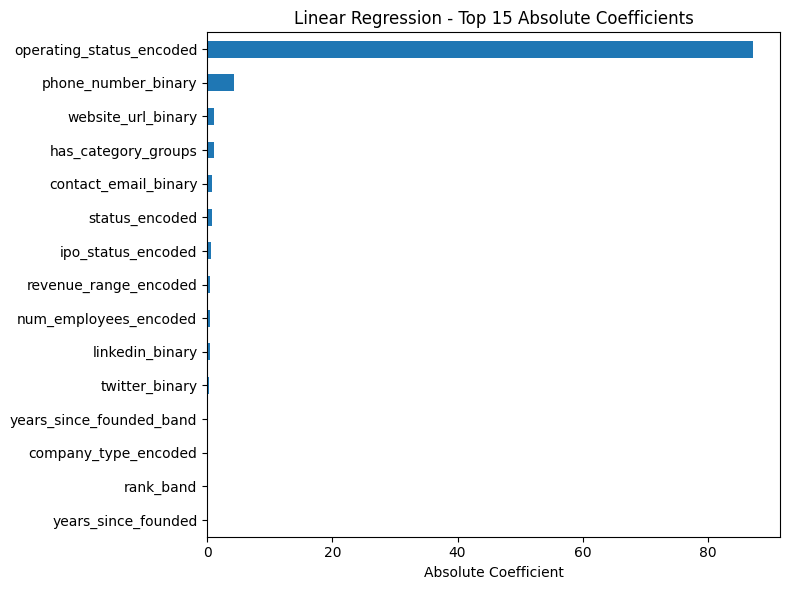

In [ ]:
# Linear Regression importance
coefs = np.abs(lr.coef_)
feat_importances = pd.Series(coefs, index=X.columns)
top15 = feat_importances.nlargest(15).sort_values(ascending=True)
top15.plot(kind='barh', figsize=(8,6))
plt.title("Linear Regression - Top 15 Absolute Coefficients")
plt.xlabel("Absolute Coefficient")
plt.tight_layout()
plt.show()

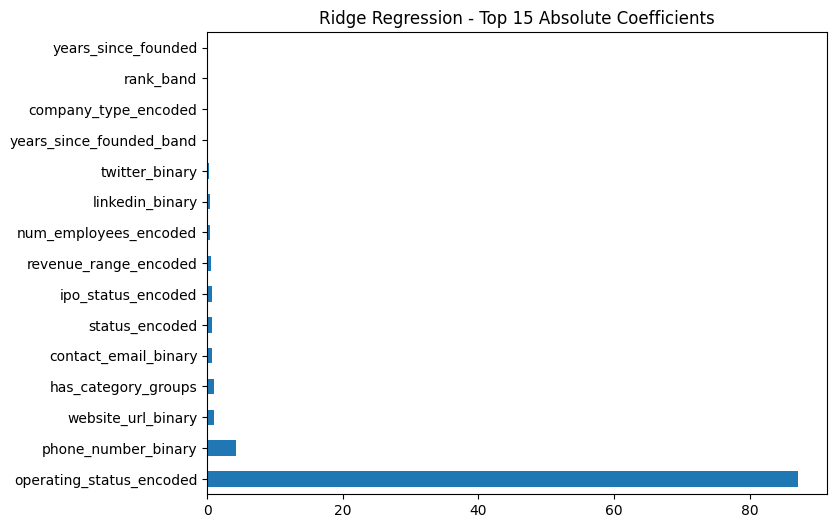

In [ ]:
# Ridge importance (using absolute coefficients)
coefs_ridge = np.abs(ridge.coef_)
feat_importances_ridge = pd.Series(coefs_ridge, index=X.columns)
feat_importances_ridge.nlargest(15).plot(kind='barh', figsize=(8,6))
plt.title("Ridge Regression - Top 15 Absolute Coefficients")
plt.show()

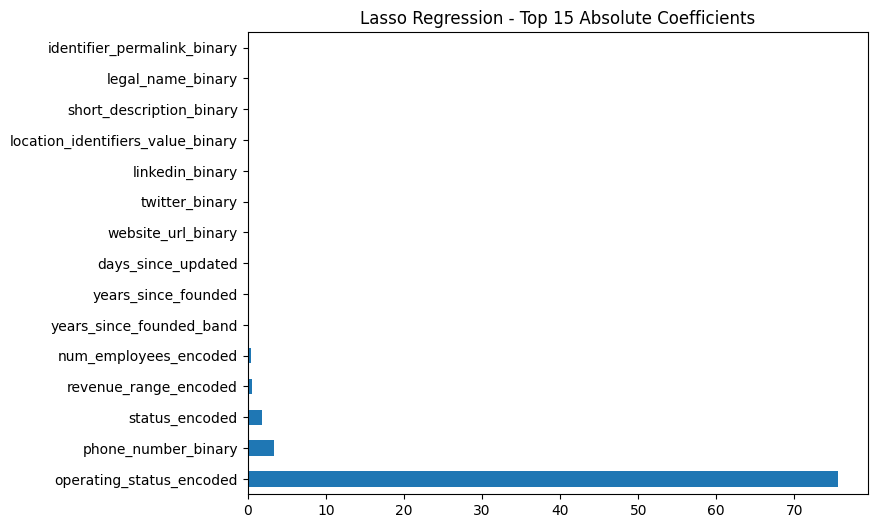

In [ ]:
# Lasso importance (using absolute coefficients)
coefs_lasso = np.abs(lasso.coef_)
feat_importances_lasso = pd.Series(coefs_lasso, index=X.columns)
feat_importances_lasso.nlargest(15).plot(kind='barh', figsize=(8,6))
plt.title("Lasso Regression - Top 15 Absolute Coefficients")
plt.show()